# ARIMA in Python 3

Based on https://github.com/williewheeler/time-series-demos/blob/master/arima/arima-python.ipynb.

In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

## 1 Load data

In [4]:
data = sm.datasets.co2.load_pandas()
y = data.data

## 2 Preprocess data

In [5]:
# The 'MS' string groups the data into buckets by the start of the month
y = y['co2'].resample('MS').mean()

# 'bfill' means that we use the value before filling in missing values
y = y.fillna(y.bfill())

y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

## 3 Visualize data

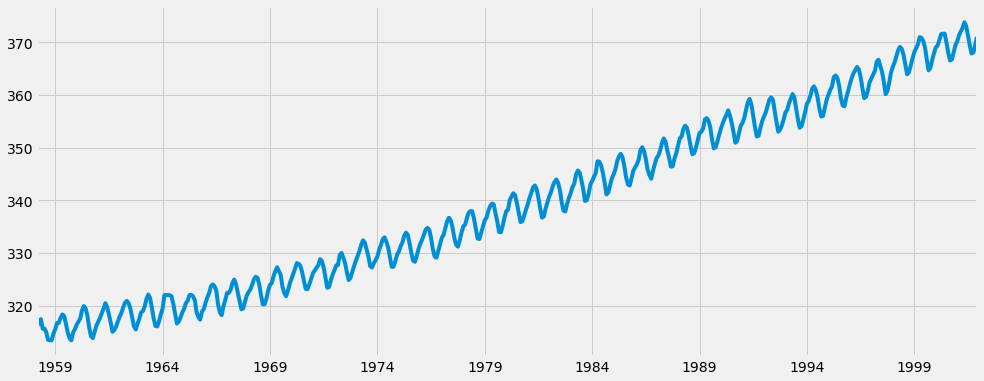

In [6]:
y.plot(figsize=(15, 6))
plt.show()

## 4 Modeling: Hyperparameter optimization via grid search

_The following is from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3_.

> There are three distinct integers `p`, `d`, `q` that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets.
> 
> - `p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
> - `d` is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
> - `q` is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
> 
> When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s`. Here, `p`, `d`, `q` are the non-seasonal parameters described above, while `P`, `D`, `Q` follow the same definition but are applied to the seasonal component of the time series. The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

We're using grid search to find the params.

In [7]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
print('Examples of parameter combos for SARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combos for SARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


The following grid search optimizes the params for best (lowest) [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion):

In [9]:
warnings.filterwarnings("ignore")

# The blog post doesn't separate the training and test sets.
# I'm doing that here. Everything up to 1997-12-31 is training.
#y_trunc = y[:'1997-12-31']

min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
#                y_trunc,
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23439D+00    |proj g|=  7.60014D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.600D-07   7.234D+00
  F =   7.2343948953241553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12): aic=7612.583429881011
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables a

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.44805D+00    |proj g|=  1.69005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     32      1     0     0   1.592D-05   6.448D+00
  F =   6.4480452698702830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 1, 12): aic=6787.343623903538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76139D+00    |proj g|=  1.67403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   4.385D-07   1.514D+00
  F =   1.5139840045289747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12): aic=1596.7111727644815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00279D+00    |proj g|=  1.23380D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.00373D+00    |proj g|=  1.57826D+01

At iterate   10    f=  9.99143D-01    |proj g|=  2.79266D+00

At iterate   15    f=  9.99122D-01    |proj g|=  6.58112D-01

At iterate   20    f=  9.98505D-01    |proj g|=  2.85655D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     68      2     0     0   4.577D-02   9.984D-01
  F =  0.99837247397511142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12): aic=1056.2878426218172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29055D+00    |proj g|=  1.17845D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64984D+00    |proj g|=  6.32635D+00

At iterate    5    f=  1.06258D+00    |proj g|=  6.84031D-01

At iterate   10    f=  9.89319D-01    |proj g|=  2.29009D-01

At iterate   15    f=  9.87419D-01    |proj g|=  5.04057D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   5.041D-05   9.874D-01
  F =  0.98741900313997855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12): aic=1044.7647913032574


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.85470D+00    |proj g|=  1.07120D-01

At iterate   10    f=  6.85235D+00    |proj g|=  2.18895D-03

At iterate   15    f=  6.57101D+00    |proj g|=  4.23050D-01

At iterate   20    f=  6.54103D+00    |proj g|=  2.12721D-01

At iterate   25    f=  6.53712D+00    |proj g|=  5.79011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     52      1     0     0   5.790D-05   6.537D+00
  F =   6.5371185882660230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 0, 12): aic=6881.048754855856
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32    102      2     0     0   2.227D-05   5.767D+00
  F =   5.7667892848094127     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(0, 0, 1, 12): aic=6072.662327619502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45777D+00    |proj g|=  3.88166D-01

At iterate    5    f=  1.30724D+00    |proj g|=  8.57565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.



At iterate    5    f=  1.17437D+00    |proj g|=  6.70126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   3.058D-07   1.174D+00
  F =   1.1743512088218653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12): aic=1241.4174716806024
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88954D+00    |proj g|=  7.21398D-01


 This problem is unconstrained.



At iterate    5    f=  6.58167D+00    |proj g|=  1.31346D-02

At iterate   10    f=  6.57878D+00    |proj g|=  1.18976D-01

At iterate   15    f=  4.82292D+00    |proj g|=  8.02168D+01

At iterate   20    f=  2.42181D+00    |proj g|=  2.55892D+02

At iterate   25    f=  2.02312D+00    |proj g|=  1.22328D+02

At iterate   30    f=  1.39124D+00    |proj g|=  3.72254D+01

At iterate   35    f=  1.18481D+00    |proj g|=  6.61415D+00

At iterate   40    f=  1.10021D+00    |proj g|=  2.30866D+01

At iterate   45    f=  1.05197D+00    |proj g|=  2.30427D+00

At iterate   50    f=  1.03333D+00    |proj g|=  7.83424D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56200D+00    |proj g|=  2.51630D-02

At iterate   10    f=  6.53258D+00    |proj g|=  3.36510D-02

At iterate   15    f=  6.52695D+00    |proj g|=  1.09352D-01

At iterate   20    f=  4.49781D+00    |proj g|=  1.87361D+01

At iterate   25    f=  3.35762D+00    |proj g|=  1.67721D+01

At iterate   30    f=  2.39500D+00    |proj g|=  7.93845D+01

At iterate   35    f=  1.19349D+00    |proj g|=  2.29047D+00

At iterate   40    f=  7.96759D-01    |proj g|=  4.58301D+01

At iterate   45    f=  7.62288D-01    |proj g|=  7.14311D+00

At iterate   50    f=  7.34317D-01    |proj g|=  1.06256D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.05857D+00    |proj g|=  5.86771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.923D-06   1.059D+00
  F =   1.0585511305685982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12): aic=1119.5957893581653
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38037D+00    |proj g|=  8.40437D-01

At iterate    5    f=  8.24062D-01    |proj g|=  2.82790D-01

At iterate   10 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   7.298D-05   6.002D-01
  F =  0.60023056912347161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 0, 12): aic=633.4425587178921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54470D-01    |proj g|=  2.69453D-01


 This problem is unconstrained.



At iterate    5    f=  3.17359D-01    |proj g|=  5.15366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     17      1     0     0   3.567D-06   3.173D-01
  F =  0.31729453883416964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 12): aic=337.79385485354646
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85504D-01    |proj g|=  4.86123D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.65258D-01    |proj g|=  1.43823D+00

At iterate   10    f=  3.52599D-01    |proj g|=  5.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   6.861D-05   3.526D-01
  F =  0.35259351332274452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 1, 12): aic=376.92837601552725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50884D-01    |proj g|=  4.96079D-05

           * * *

 This problem is unconstrained.
 This problem is unconstrained.


    2      1      5      1     0     0   1.364D-05   4.509D-01
  F =  0.45088373649262353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 0, 12): aic=478.32969079023997
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62371D-01    |proj g|=  2.18977D-01

At iterate    5    f=  3.19123D-01    |proj g|=  5.41952D-01

At iterate   10    f=  3.03923D-01    |proj g|=  5.64370D-03

At iterate   15    f=  3.01639D-01    |proj g|=  1.07798D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     46      1     0     0   1.078D-02   3.016D-01
  F =  0.30163936699706095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12): aic=323.32461408090813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43891D+00    |proj g|=  1.95608D+00

At iterate    5    f=  1.29961D+00    |proj g|=  2.04836D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52013D-01    |proj g|=  8.36236D-01

At iterate    5    f=  2.85304D-01    |proj g|=  3.64837D-01

At iterate   10    f=  2.81840D-01    |proj g|=  1.41906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   4.234D-05   2.818D-01
  F =  0.28183925863986170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12): aic=302.4949000891345
RUNNING THE L-BFGS

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.74006D-01    |proj g|=  2.47343D-01

At iterate   15    f=  3.27917D-01    |proj g|=  4.03563D-01

At iterate   20    f=  3.12928D-01    |proj g|=  1.06651D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   4.002D-04   3.129D-01
  F =  0.31292766659177074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12): aic=337.19990525454284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 1, 0, 12): aic=433.0863608096836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53731D-01    |proj g|=  8.34383D-01


 This problem is unconstrained.



At iterate    5    f=  2.80420D-01    |proj g|=  4.65725D-01

At iterate   10    f=  2.62224D-01    |proj g|=  2.51744D-02
  ys=-4.408E-03  -gs= 1.826E-04 BFGS update SKIPPED

At iterate   15    f=  2.60035D-01    |proj g|=  7.45523D-03

At iterate   20    f=  2.60013D-01    |proj g|=  1.32714D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.59999D-01    |proj g|=  6.30217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     87      2     1     0   6.302D-03   2.600D-01
  F =  0.25999904924435324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12): aic=281.5189998050596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59020D+00    |proj g|=  4.07098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.39003D+00    |proj g|=  1.82295D+01

At iterate   10    f=  1.37228D+00    |proj g|=  4.51774D-01

At iterate   15    f=  1.36672D+00    |proj g|=  6.67649D+00

At iterate   20    f=  1.18247D+00    |proj g|=  4.74169D-01

At iterate   25    f=  1.17485D+00    |proj g|=  3.67093D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     50      1     0     0   3.546D-07   1.175D+00
  F =   1.1748436016223314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 0, 1, 12): aic=1241.9354689066927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.48226D-01    |proj g|=  4.08922D-01

At iterate   10    f=  3.18782D-01    |proj g|=  3.10694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     27      1     0     0   2.631D-05   3.187D-01
  F =  0.31871640789205574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12): aic=341.28966110244266
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13553D+00    |proj g|=  7.02833D-01

At iterate    5 

 This problem is unconstrained.



At iterate   15    f=  5.45047D-01    |proj g|=  1.45912D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     38      1     0     0   1.186D-01   5.450D-01
  F =  0.54504713266462856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 0, 12): aic=579.3895835631893
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12698D+00    |proj g|=  7.17839D-01

At iterate    5    f=  5.00405D-01    |proj g|=  4.01806D-01


 This problem is unconstrained.



At iterate   10    f=  4.60118D-01    |proj g|=  9.37808D+00

At iterate   15    f=  4.35484D-01    |proj g|=  1.19827D+00

At iterate   20    f=  4.28446D-01    |proj g|=  1.35586D+00

At iterate   25    f=  3.48266D-01    |proj g|=  3.49111D+00

At iterate   30    f=  3.44672D-01    |proj g|=  9.90737D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     75      2     0     0   2.803D-05   3.447D-01
  F =  0.34466925421410977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(1, 0, 1, 12): aic=370.59205543324344
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12946D+00    |proj g|=  2.49990D+00

At iterate    5    f=  4.95731D-01    |proj g|=  1.56171D+00

At iterate   10    f=  4.46816D-01    |proj g|=  4.98488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   1.138D-05   4.468D-01
  F =  0.44681562997082785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04621D-01    |proj g|=  4.54004D-01

At iterate    5    f=  4.39843D-01    |proj g|=  1.23668D+00

At iterate   10    f=  3.12607D-01    |proj g|=  6.89729D-01

At iterate   15    f=  3.05697D-01    |proj g|=  7.24454D-03

At iterate   20    f=  3.05689D-01    |proj g|=  3.72903D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   3.729D-06   3.057D-01
  F =  0.30568868744230965     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.35526D+00    |proj g|=  6.37256D+00

At iterate   10    f=  1.34955D+00    |proj g|=  1.77187D+00

At iterate   15    f=  1.31900D+00    |proj g|=  3.39753D+01

At iterate   20    f=  1.29950D+00    |proj g|=  4.04779D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     42      1     0     0   6.888D-02   1.299D+00
  F =   1.2990575933159905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12): aic=1372.6085881684219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26723D-01    |proj g|=  4.49460D-01

At iterate    5    f=  3.05800D-01    |proj g|=  1.26883D+00

At iterate   10    f=  2.83071D-01    |proj g|=  1.00723D-01

At iterate   15    f=  2.82957D-01    |proj g|=  8.77340D-02

At iterate   20    f=  2.82916D-01    |proj g|=  9.95876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   1.058D-04   2.829D-01
  F =  0.28291576343351266     

CONVERG

 This problem is unconstrained.


At iterate   25    f=  5.74753D-01    |proj g|=  2.20681D-01

At iterate   30    f=  5.73963D-01    |proj g|=  7.27908D+00

At iterate   35    f=  5.61820D-01    |proj g|=  4.13299D+00

At iterate   40    f=  5.56461D-01    |proj g|=  5.57009D+00

At iterate   45    f=  5.52537D-01    |proj g|=  2.97581D+00

At iterate   50    f=  5.50546D-01    |proj g|=  1.79181D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     0     0   1.792D+00   5.505D-01
  F =  0.55054555525615534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(1, 0, 0, 12): aic=587.1739241294754


 This problem is unconstrained.



At iterate   10    f=  8.70079D-01    |proj g|=  4.90916D+00

At iterate   15    f=  5.60802D-01    |proj g|=  3.08716D+01

At iterate   20    f=  5.37948D-01    |proj g|=  2.37836D-01

At iterate   25    f=  5.29030D-01    |proj g|=  1.47823D+01

At iterate   30    f=  4.61345D-01    |proj g|=  4.88548D+00

At iterate   35    f=  3.88021D-01    |proj g|=  4.33769D+00

At iterate   40    f=  3.70520D-01    |proj g|=  4.10913D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     76      1     0     0   2.689D-01   3.701D-01
  F =  0.37014990588570157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  4.04513D-01    |proj g|=  2.29921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.697D-05   4.045D-01
  F =  0.40451230651829340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12): aic=433.54694645724464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68407D-01    |proj g|=  5.00452D-01


 This problem is unconstrained.



At iterate    5    f=  4.23351D-01    |proj g|=  1.40174D+00

At iterate   10    f=  2.69703D-01    |proj g|=  2.60017D-01

At iterate   15    f=  2.62212D-01    |proj g|=  4.39712D-02

At iterate   20    f=  2.62154D-01    |proj g|=  1.71401D-02

At iterate   25    f=  2.62134D-01    |proj g|=  2.99887D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     39      1     0     0   1.482D-05   2.621D-01
  F =  0.26213420041138014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12): aic=285.7651788327719
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10018D+00    |proj g|=  3.22904D-01

At iterate    5    f=  1.00280D+00    |proj g|=  3.93168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.566D-07   1.003D+00
  F =   1.0027901059336537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 0, 1, 12): aic=1060.9351914422036
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   5.939D-05   5.672D-01
  F =  0.56724455159091847     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 1, 0, 12): aic=600.7412682736463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69544D-01    |proj g|=  8.63126D-01

At iterate    5    f=  2.91949D-01    |proj g|=  1.46853D-01

At iterate   10    f=  2.91003D-01    |proj g|=  2.81110D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     59      2     0     0   8.588D-05   2.910D-01
  F =  0.29100091571647974     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(0, 1, 1, 12): aic=312.13296333373665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73905D-01    |proj g|=  5.91870D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.75628D-01    |proj g|=  3.63884D-01

At iterate   10    f=  5.58616D-01    |proj g|=  3.93378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   3.522D-05   5.586D-01
  F =  0.55861575619161363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 0, 12): aic=593.6637755135775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05532D-01    |proj g|=  7.73894D-01


 This problem is unconstrained.



At iterate    5    f=  5.59749D-01    |proj g|=  7.47555D-01

At iterate   10    f=  3.25635D-01    |proj g|=  1.86130D-01

At iterate   15    f=  3.24350D-01    |proj g|=  1.52122D-02

At iterate   20    f=  3.24343D-01    |proj g|=  1.40595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     40      1     0     0   1.406D-04   3.243D-01
  F =  0.32434329444230975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12): aic=349.2091457533099
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 0, 12): aic=440.13758845170025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71434D-01    |proj g|=  8.61170D-01


 This problem is unconstrained.



At iterate    5    f=  2.88784D-01    |proj g|=  2.03587D-01

At iterate   10    f=  2.71849D-01    |proj g|=  6.64751D-02

At iterate   15    f=  2.71623D-01    |proj g|=  3.01852D-03

At iterate   20    f=  2.71618D-01    |proj g|=  5.74959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   5.750D-05   2.716D-01
  F =  0.27161846227609188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12): aic=293.7426223144487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06818D+00    |proj g|=  3.14713D-01

At iterate    5    f=  9.92474D-01    |proj g|=  2.76232D-03

At iterate   10    f=  9.92456D-01    |proj g|=  1.12933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.416D-07   9.925D-01
  F =  0.99245596236294864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12): aic=1052.063672405822
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.77558D-01    |proj g|=  3.74669D-01

At iterate   10    f=  2.73914D-01    |proj g|=  9.28261D-03

At iterate   15    f=  2.73705D-01    |proj g|=  1.67373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.868D-05   2.737D-01
  F =  0.27370475869291250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12): aic=295.93740614494396
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.62407D-01    |proj g|=  6.08398D-01

At iterate   10    f=  5.47159D-01    |proj g|=  5.87660D-02

At iterate   15    f=  5.40898D-01    |proj g|=  4.28547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.829D-05   5.407D-01
  F =  0.54074592314525494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12): aic=576.8647111488082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.76116D-01    |proj g|=  4.65682D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41830D-02

At iterate   15    f=  2.54552D-01    |proj g|=  3.10521D-03

At iterate   20    f=  2.54546D-01    |proj g|=  2.95416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     48      1     0     0   2.049D-03   2.545D-01
  F =  0.25454416872469338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12): aic=277.78046549837745


In [10]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=277.78046549837745, min_params=(1, 1, 1), min_params_seasonal=(1, 1, 1, 12)


## 5 Model fit and diagnostics

We kept the best model from the HPO, so now we can explore it.

In [11]:
results = min_model # To align with the blog post
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3180,0.092,3.444,0.001,0.137,0.499
ma.L1,-0.6255,0.076,-8.178,0.000,-0.775,-0.476
ar.S.L12,0.0010,0.001,1.732,0.083,-0.000,0.002
ma.S.L12,-0.8766,0.026,-33.766,0.000,-0.928,-0.826
sigma2,0.0971,0.004,22.641,0.000,0.089,0.106


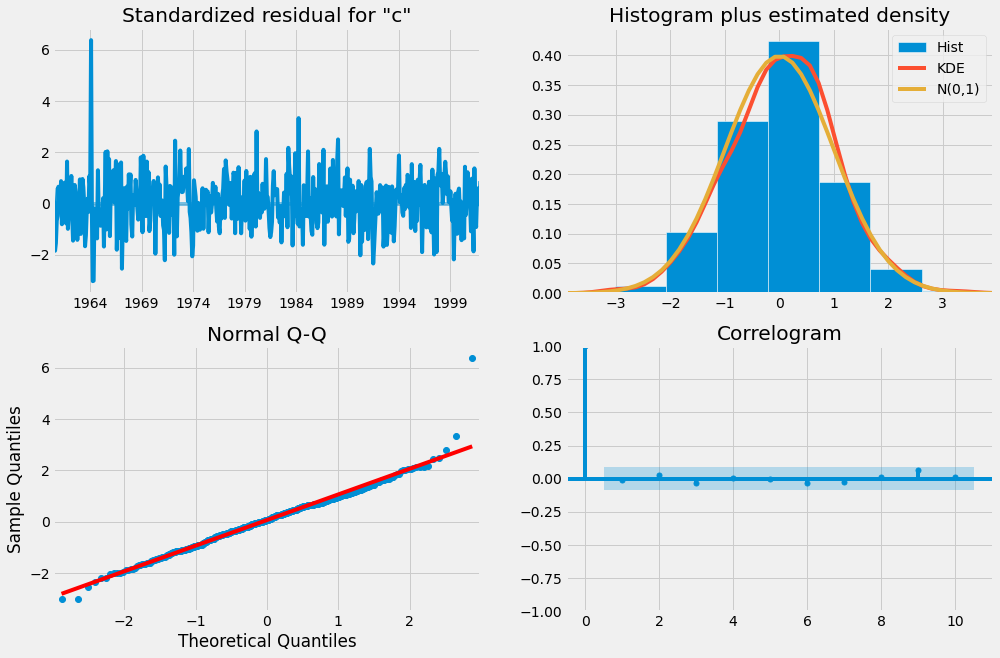

In [12]:
# KDE = kernel density estimate
# Q-Q plot = quantile/quantile
results.plot_diagnostics(figsize=(15, 10))
plt.show()

References:

- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

## 6 Model validation

Note: The blog post doesn't use separate training and test sets.

### 6.1 Static forecasts

In [13]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

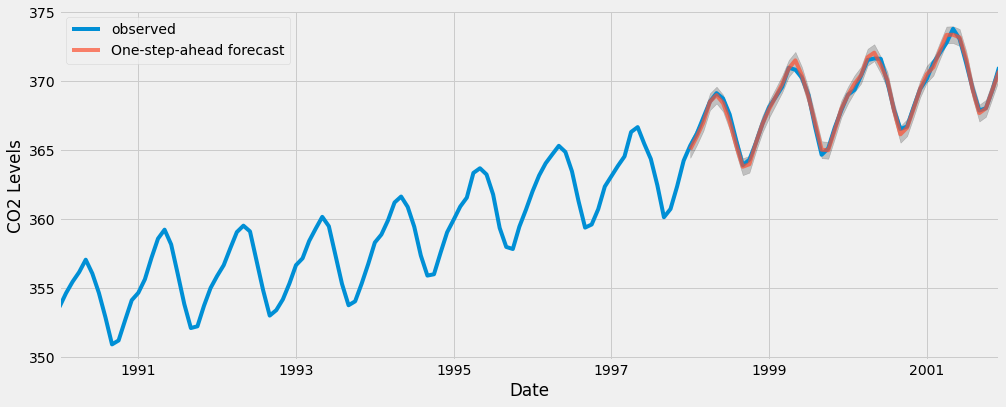

In [14]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step-ahead forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [15]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


### 6.2 Dynamic forecasts

In [16]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

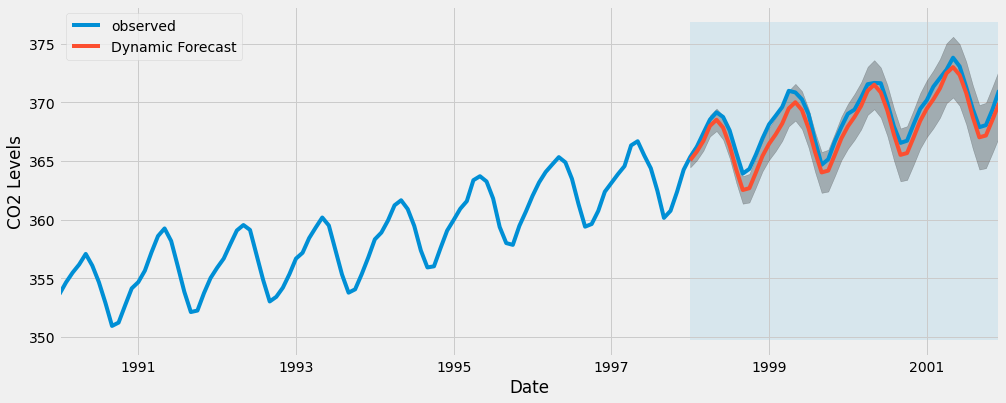

In [17]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(
    pred_dynamic_ci.index,
    pred_dynamic_ci.iloc[:, 0],
    pred_dynamic_ci.iloc[:, 1],
    color='k',
    alpha=.25)

ax.fill_betweenx(
    ax.get_ylim(),
    pd.to_datetime('1998-01-01'),
    y.index[-1],
    alpha=.1,
    zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [18]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


## 7 Producing and visualizing forecasts

In [19]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

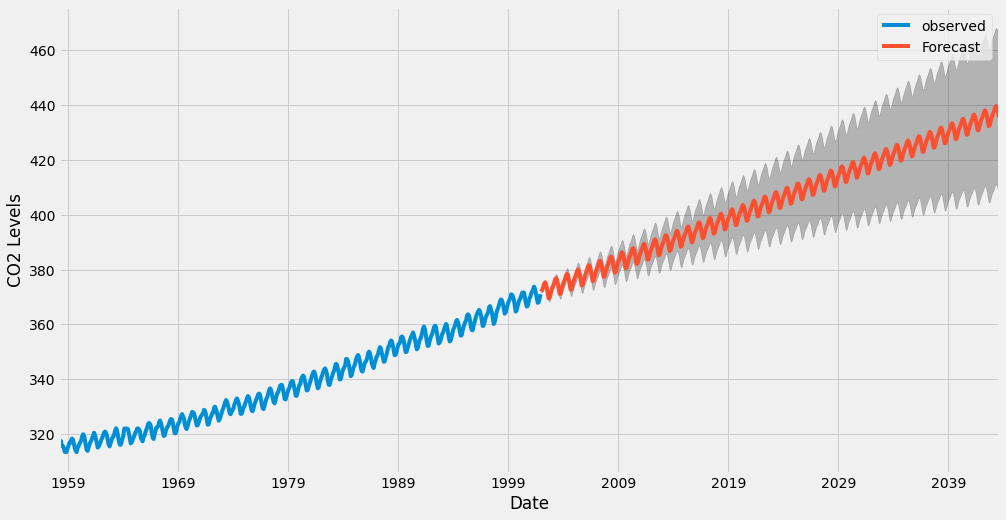

In [20]:
ax = y.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()